# Band Excitation Piezoresponse Force Microscopy of $PbZr_{0.2}Ti_{0.8}O_3$

Film grown and measurements conducted by Joshua C. Agar at Oak Ridge National Laboratory

This dataset has been the subject of 4 manuscripts: 

1. Agar, J., Damodaran, A. R., Pandya, S., C, Cao, Y., Vasudevan, R. K., Xu, R., Saremi, S., Li, Q., Kim, J., McCarter, M. R., Dedon, L. R., Angsten, T., Balke, N., Jesse, S., Asta, M., Kalinin, S. V. & Martin, L. W. Three-State Ferroelastic Switching and Large Electromechanical Responses in PbTiO<sub>3 Thin Films. Adv. Mater. 29, 1702069 (2017). [doi:10.1002/adma.201702069](https://onlinelibrary.wiley.com/doi/10.1002/adma.201702069)
2. Agar, J. C., Cao, Y., Naul, B., Pandya, S., van der Walt, S., Luo, A. I., Maher, J. T., Balke, N., Jesse, S., Kalinin, S. V., Vasudevan, R. K. & Martin, L. W. Machine detection of enhanced electromechanical energy conversion in PbZr<sub>0.2</sub>Ti<sub>0.8</sub>O<sub>3</sub> thin films. Adv. Mater. 30, e1800701 (2018). [doi:10.1002/adma.201800701](https://onlinelibrary.wiley.com/doi/abs/10.1002/adma.201800701)
3. Griffin, L. A., Gaponenko, I. & Bassiri-Gharb, N. Better, Faster, and Less Biased Machine Learning: Electromechanical Switching in Ferroelectric Thin Films. Adv. Mater. e2002425 (2020). [doi:10.1002/adma.202002425](https://onlinelibrary.wiley.com/doi/abs/10.1002/adma.202002425)
4. Qin, S., Guo, Y., Kaliyev, A. T. & Agar, J. C. Why it is Unfortunate that Linear Machine Learning ‘Works’ so well in Electromechanical Switching of Ferroelectric Thin Films. Adv. Mater. e2202814 (2022). [doi:10.1002/adma.202202814](https://onlinelibrary.wiley.com/doi/10.1002/adma.202202814)

## Import Packages

In [3]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch


from m3_learning.nn.random import random_seed
from m3_learning.viz.style import style
from m3_learning.be.util import print_be_tree
from m3_learning.be.processing import convert_amp_phase, fit_loop_function, SHO_Fitter, SHO_fit_to_array, loop_lsqf
from m3_learning.viz.layout import layout_fig
from m3_learning.util.h5_util import make_dataset, make_group
from m3_learning.util.file_IO import download_and_unzip
from scipy.signal import resample
from scipy import fftpack



style("default")
random_seed(seed=42)

%matplotlib inline

default set for seaborn
default set for matplotlib
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loading data for SHO fitting


In [4]:
path = r"./"

In [5]:
url = 'https://zenodo.org/record/7297755/files/data_file.h5?download=1'
filename = 'data_file.h5'
save_path = './'

download_and_unzip(filename, url, save_path)

Using files already downloaded


Prints the Tree to show the Data Structure

In [6]:
print_be_tree(path + "data_file.h5")

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Guess
      ├ Guess-Loop_Fit_000
        ------------------
        ├ Fit
        ├ Fit_Loop_Parameters
        ├ Guess
        ├ Guess_Loop_Parameters
        ├ Loop_Metrics
        ├ Loop_Metrics_Indices
        ├ Loop_Metrics_Values
        ├ Projected_Loops
        ├ completed_fit_positions
        ├ completed_guess_positions
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ completed_fit_positions
      ├ completed_guess_positions
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
    

## SHO Fitting
**Note**: this code takes around 15 minutes to execute

In [7]:
SHO_Fitter(path + "data_file.h5")

C:\Users\jca92\AppData\Roaming\Python\Python310\site-packages\sidpy\sid\translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '


File is already Pycroscopy ready.
Working on:
./data_file.h5
['Y', 'X'] [60, 60]


SHO Fits will be written to:
.\data_file.h5


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]
Returned previously computed results at /Raw_Data-SHO_Fit_000

Note: SHO_Fit has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override

### Extract Data

In [8]:
# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of samples per SHO fit
num_bins = h5_f["Measurement_000"].attrs["num_bins"]

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

# number of pixels in x and y dimensions
num_pix_1d = int(np.sqrt(num_pix))

# number of DC voltage steps
voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# sampling rate
sampling_rate = h5_f["Measurement_000"].attrs["IO_rate_[Hz]"]

# BE bandwidth
be_bandwidth = h5_f["Measurement_000"].attrs["BE_band_width_[Hz]"]

# BE center frequency
be_center_frequency = h5_f["Measurement_000"].attrs["BE_center_frequency_[Hz]"]

# Frequency Vector in Hz
frequency_bin = h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]

# Resampled frequency vector
wvec_freq = resample(frequency_bin, 80)

# extracting the excitation waveform
be_waveform = h5_f["Measurement_000"]["Channel_000"]["Excitation_Waveform"]

# extracting spectroscopic values
spectroscopic_values = h5_f["Measurement_000"]["Channel_000"]["Spectroscopic_Values"]

# get raw data (real and imaginary combined)
raw_data = h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]

### Saves the Data

In [9]:
shape = h5_f["Measurement_000"]["Channel_000"]["Raw_Data"].shape

#creates the necessary structure in the H5_file
make_group(h5_f["Measurement_000"]["Channel_000"], 'complex')
make_group(h5_f["Measurement_000"]["Channel_000"], 'magn_spec')
make_dataset(h5_f["Measurement_000"]["Channel_000"]['complex'], 'real', np.real(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]))
make_dataset(h5_f["Measurement_000"]["Channel_000"]['complex'], 'imag', np.imag(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]))

amp, phase = convert_amp_phase(raw_data)

make_dataset(h5_f["Measurement_000"]["Channel_000"]['magn_spec'], 'amp', amp)
make_dataset(h5_f["Measurement_000"]["Channel_000"]['magn_spec'], 'phase', phase)

could not add group - it might already exist
could not add group - it might already exist


### Plots the SHO Fit Results

In [11]:
dc_voltage = h5_f["Measurement_000"]["Channel_000"]['Raw_Data-SHO_Fit_000']['Spectroscopic_Values'][0,1::2]
SHO_fit_results = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

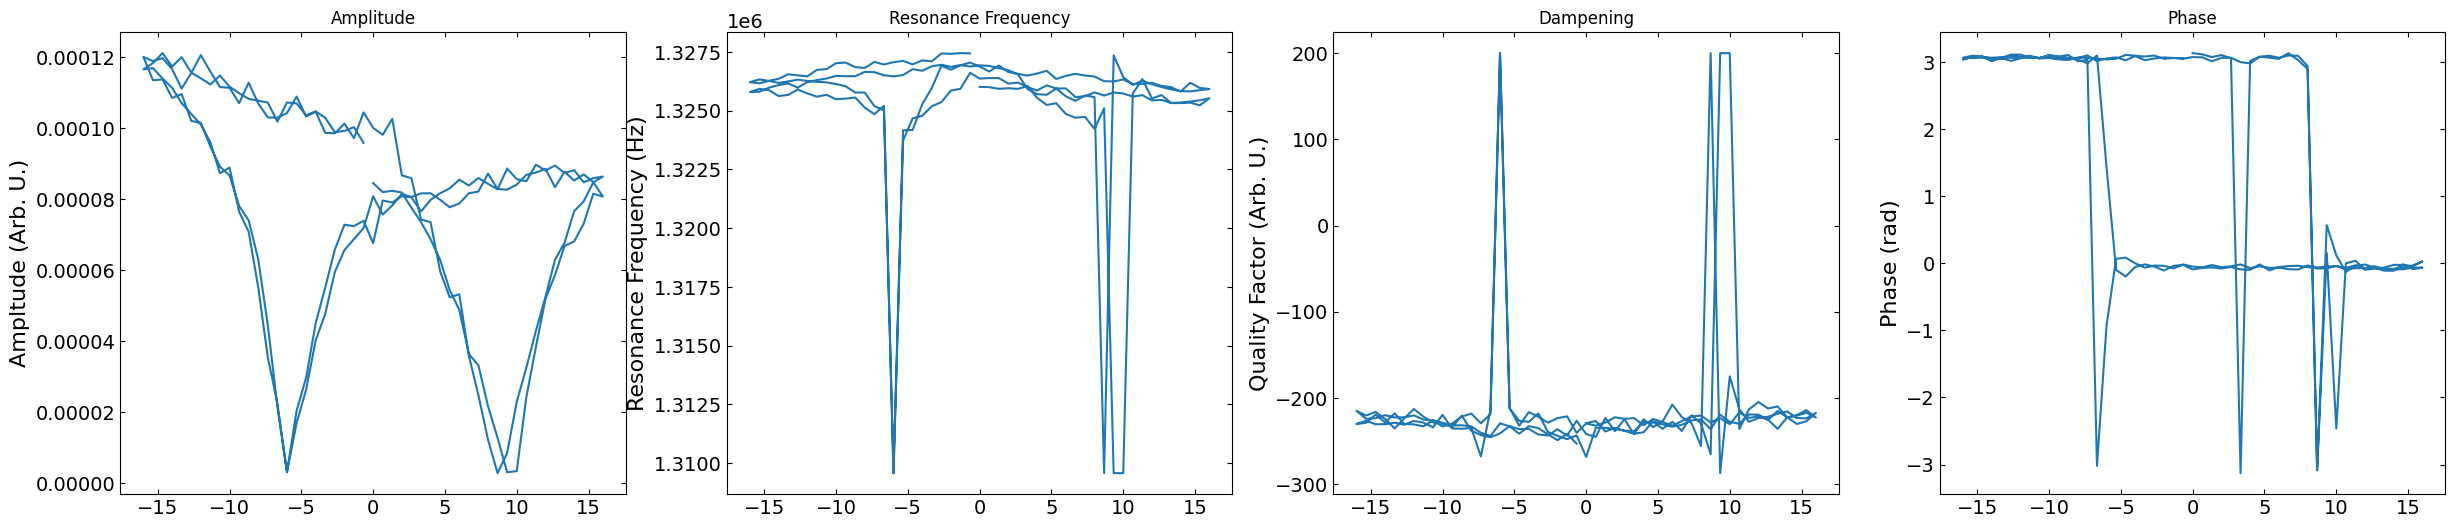

In [12]:
pix = np.random.randint(0,3600)

figs, ax = layout_fig(4, 4, figsize=(30, 6))

labels = [{'title': "Amplitude",
            'y_label': "Ampltude (Arb. U.)"},
         {'title': "Resonance Frequency",
            'y_label': "Resonance Frequency (Hz)"},
         {'title': "Dampening",
            'y_label': "Quality Factor (Arb. U.)"},
        {'title': "Phase",
            'y_label': "Phase (rad)"}]

for i, ax in enumerate(ax):
    ax.plot(dc_voltage, SHO_fit_results[pix,1::2,i])
    ax.set_title(labels[i]['title'])
    ax.set_ylabel(labels[i]['y_label'])

### Visualize Raw Data

860 14
Number of time steps: 4096.0


c:\Users\jca92\.conda\envs\rapid_fitting\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


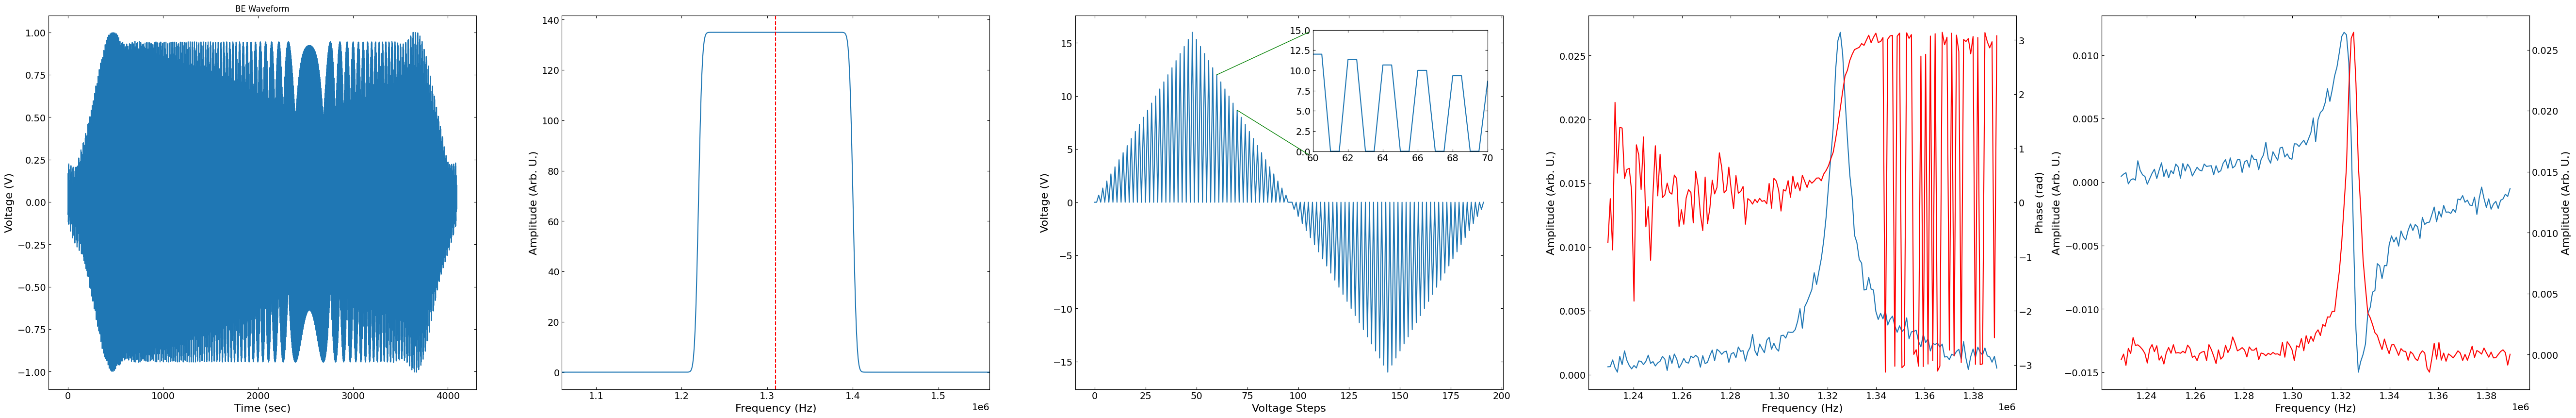

In [13]:
# Selects a random point and timestep to plot
pixel = np.random.randint(0,h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'][:].shape[0])
timestep = np.random.randint(h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'][:].shape[0]/num_bins)

print(pixel, timestep)
fig, ax = layout_fig(5, 5, figsize=(6 * 11, 10))

be_timesteps = len(be_waveform) / 4
print("Number of time steps: " + str(be_timesteps))
ax[0].plot(be_waveform[: int(be_timesteps)])
ax[0].set(xlabel="Time (sec)", ylabel="Voltage (V)")
ax[0].set_title("BE Waveform")

resonance_graph = np.fft.fft(be_waveform[: int(be_timesteps)])
fftfreq = fftpack.fftfreq(int(be_timesteps)) * sampling_rate
ax[1].plot(
    fftfreq[: int(be_timesteps) // 2], np.abs(resonance_graph[: int(be_timesteps) // 2])
)
ax[1].axvline(
    x=be_center_frequency,
    ymax=np.max(resonance_graph[: int(be_timesteps) // 2]),
    linestyle="--",
    color="r",
)
ax[1].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax[1].set_xlim(
    be_center_frequency - be_bandwidth - be_bandwidth * 0.25,
    be_center_frequency + be_bandwidth + be_bandwidth * 0.25,
)

hysteresis_waveform = (
    spectroscopic_values[1, ::165][192:] * spectroscopic_values[2, ::165][192:]
)
x_start = 120
x_end = 140

ax[2].plot(hysteresis_waveform)
ax_new = fig.add_axes([0.52, 0.6, 0.3/5.5, 0.25])
ax_new.plot(np.repeat(hysteresis_waveform, 2))
ax_new.set_xlim(x_start, x_end)
ax_new.set_ylim(0, 15)
ax_new.set_xticks(np.linspace(x_start, x_end, 6))
ax_new.set_xticklabels([60, 62, 64, 66, 68, 70])
fig.add_artist(
    ConnectionPatch(
        xyA=(x_start // 2, hysteresis_waveform[x_start // 2]),
        coordsA=ax[2].transData,
        xyB=(105, 16),
        coordsB=ax[2].transData,
        color="green",
    )
)
fig.add_artist(
    ConnectionPatch(
        xyA=(x_end // 2, hysteresis_waveform[x_end // 2]),
        coordsA=ax[2].transData,
        xyB=(105, 4.5),
        coordsB=ax[2].transData,
        color="green",
    )
)
ax[2].set_xlabel("Voltage Steps")
ax[2].set_ylabel("Voltage (V)")

ax[3].plot(
    frequency_bin,
    h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'][:].reshape(num_pix, -1, num_bins)[pixel, timestep],
)
ax[3].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax2 = ax[3].twinx()
ax2.plot(
    frequency_bin,
    h5_f["Measurement_000"]["Channel_000"]['magn_spec']['phase'][:].reshape(num_pix, -1, num_bins)[pixel, timestep],
    "r",
)
ax2.set(xlabel="Frequency (Hz)", ylabel="Phase (rad)");

ax[4].plot(frequency_bin, h5_f["Measurement_000"]["Channel_000"]['complex']['real'][pixel].reshape(-1, num_bins)[timestep], label="Real")
ax[4].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax3 = ax[4].twinx()
ax3.plot(
    frequency_bin, h5_f["Measurement_000"]["Channel_000"]['complex']['imag'][pixel].reshape(-1, num_bins)[timestep],'r', label="Imaginary")
ax3.set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)");

### Visualize the SHO Fit Results

In [14]:
# create a list for parameters
fit_results_list = []
for sublist in np.array(
    h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"]
):
    for item in sublist:
        for i in item:
            fit_results_list.append(i)

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

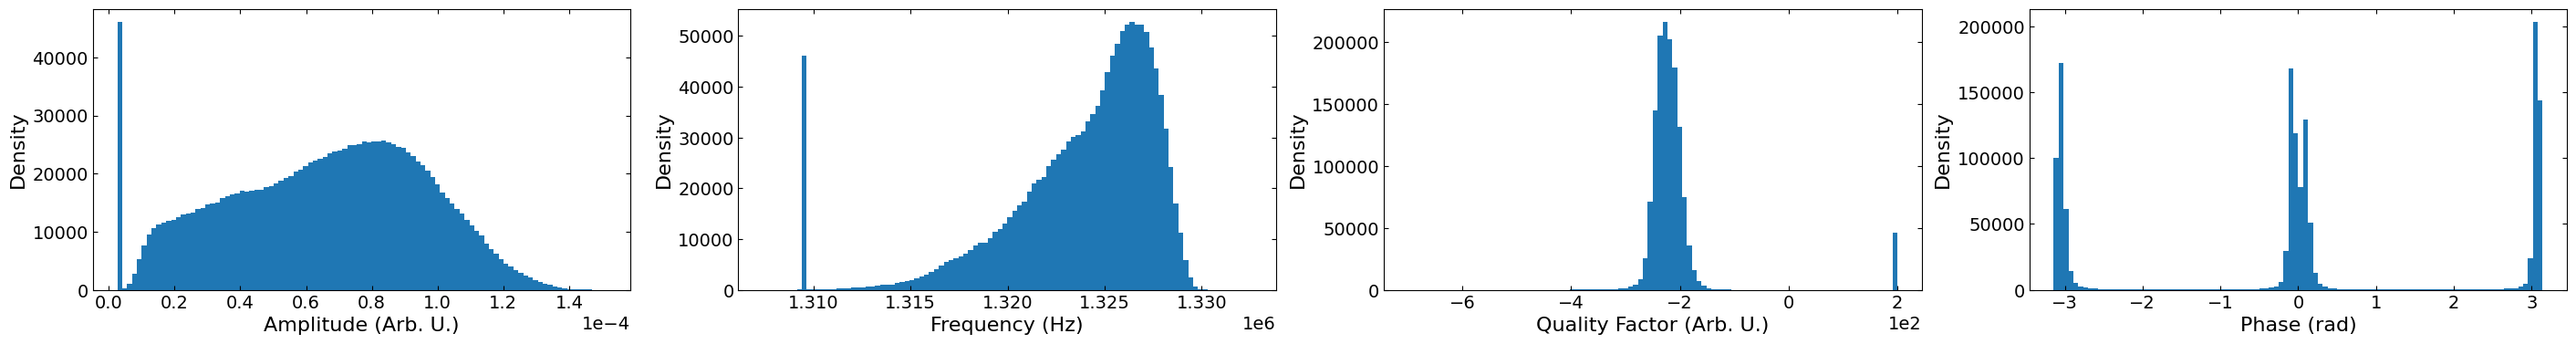

In [15]:
# check distributions of each parameter before and after scaling
fig, axs = layout_fig(4, 4, figsize=(35, 4))

units = [
    "Amplitude (Arb. U.)",
    "Frequency (Hz)",
    "Quality Factor (Arb. U.)",
    "Phase (rad)",
]

for i in range(4):
    axs[i].hist(fit_results_list[:, :, i].flatten(), 100)

i = 0
for i, ax in enumerate(axs.flat):
    ax.set(xlabel=units[i], ylabel="Density")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

# Piezoelectric Hysteresis Loops

In [16]:
h5_main = h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Guess"]
h5_loop_fit, h5_loop_group = fit_loop_function(h5_f, h5_main)

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess-Loop_Fit_000" (11 members)>]

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess-Loop_Fit_000" (11 members)>]
Returned previously computed results at /Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess-Loop_Fit_000

Note: Loop_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 grou

C:\Users\jca92\AppData\Roaming\Python\Python310\site-packages\pyUSID\io\hdf_utils\simple.py:888: UserWarning: A dataset named: Guess_Loop_Parameters already exists in group: /Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))
C:\Users\jca92\AppData\Roaming\Python\Python310\site-packages\pyUSID\io\hdf_utils\simple.py:888: UserWarning: A dataset named: Fit_Loop_Parameters already exists in group: /Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Guess-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))


In [17]:
# Formats the data for viewing
proj_nd_shifted = loop_lsqf(h5_f)
proj_nd_shifted_transposed = np.transpose(proj_nd_shifted, (1, 0, 2, 3))

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


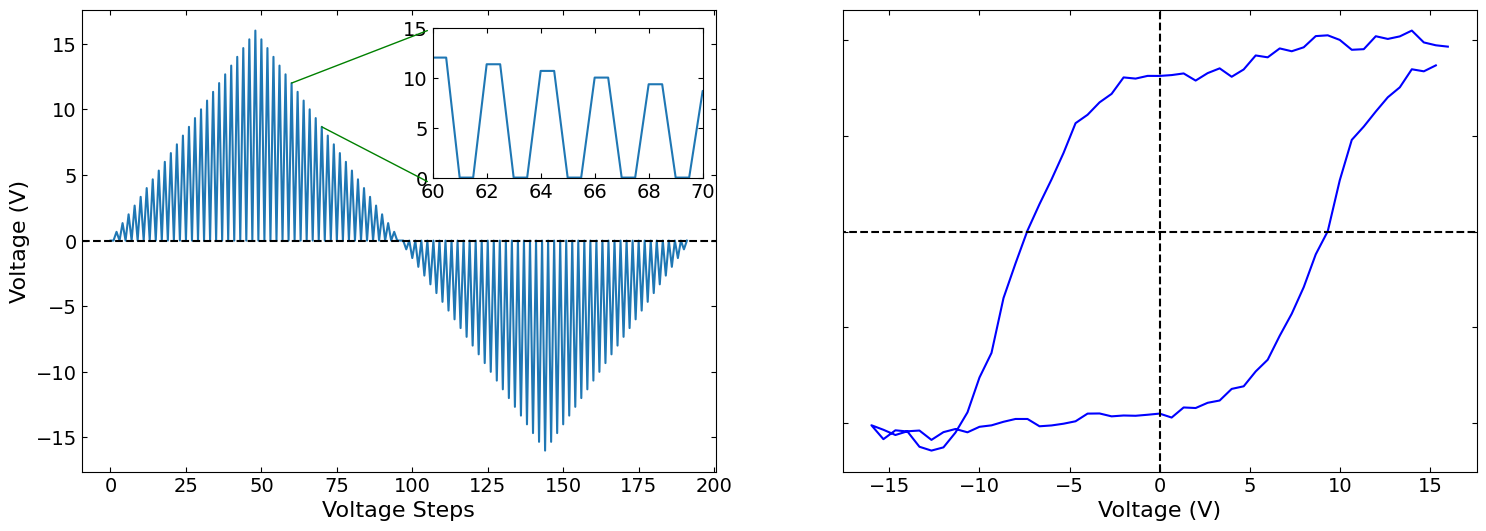

In [18]:
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=2)
hysteresis_waveform = (
    spectroscopic_values[1, ::165][192:] * spectroscopic_values[2, ::165][192:]
)
x_start = 120
x_end = 140

axs[0].plot(hysteresis_waveform)
ax_new = fig.add_axes([0.32, 0.6, 0.15, 0.25])
ax_new.plot(np.repeat(hysteresis_waveform, 2))
ax_new.set_xlim(x_start, x_end)
ax_new.set_ylim(0, 15)
ax_new.set_xticks(np.linspace(x_start, x_end, 6))
ax_new.set_xticklabels([60, 62, 64, 66, 68, 70])
fig.add_artist(
    ConnectionPatch(
        xyA=(x_start // 2, hysteresis_waveform[x_start // 2]),
        coordsA=axs[0].transData,
        xyB=(105, 16),
        coordsB=axs[0].transData,
        color="green",
    )
)
fig.add_artist(
    ConnectionPatch(
        xyA=(x_end // 2, hysteresis_waveform[x_end // 2]),
        coordsA=axs[0].transData,
        xyB=(105, 4.5),
        coordsB=axs[0].transData,
        color="green",
    )
)
axs[0].set_xlabel("Voltage Steps")
axs[0].set_ylabel("Voltage (V)")

i = np.random.randint(0, num_pix_1d, 2)
axs[1].plot(dc_voltage[24:120], proj_nd_shifted_transposed[i[0], i[1], :, 3], "blue")
axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
axs[1].set(xlabel="Voltage (V)", ylabel="Amplitude (Arb. U.)")
axs[1].label_outer()

axs[0].axhline(y=0, xmax=200, linestyle="--", color="black")
axs[1].axhline(y=0, xmin=-16, xmax=16, linestyle="--", color="black")
axs[1].axvline(x=0, linestyle="--", color="black")

In [19]:
# Closes the h5_file
h5_f.close()